In [1]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq', 'msdai']:
    os.chdir('/home/ms/github/fxpred')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
else:
    os.chdir('/home/RDC/fisertiz/Schreibtisch/phd/paper1_fxpred')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize
from transformer_architecture_elements import Time2Vector, SingleAttention, MultiAttention, TransformerEncoder

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [2]:
filename = 'Benchmark/trained_models/LSTM_univariate2_classification____0100.hdf5'  # Classification model
# filename = 'Benchmark/trained_models/LSTM_univariate2_with_close_price____0150.hdf5'  # Regression model
# filename = 'content/Transformer+TimeEmbedding2_minmax____0300.hdf5'
# filename = 'content/FXTransformerMulti0093.hdf5'
# filename = 'content/Transformer+TimeEmbeddingClassification0010.hdf5'

my_LSTM_model = tf.keras.models.load_model(
    filename,
    custom_objects={
        'kl_divergence': kullback_leibler_divergence,
        'Time2Vector': Time2Vector,
        'SingleAttention': SingleAttention,
        'MultiAttention': MultiAttention,
        'TransformerEncoder': TransformerEncoder
    }
)
lag = my_LSTM_model.input_shape[1]
print(f'lag: {lag}')
if my_LSTM_model.layers[-1].activation == tf.keras.activations.softmax:
    nn_type_classification = True
    h = 1
else:
    nn_type_classification = False
    h = my_LSTM_model.output_shape[1]
print(f'h: {h}')

lag: 256
h: 1


In [3]:
def predictions(my_model, X_test, sc=None):
    LSTM_prediction = my_model.predict(X_test)
    if sc is not None:
        LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    return LSTM_prediction

In [4]:
dtype = np.float32  # np.float64
tf.keras.backend.set_floatx('float32')

df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target_price = target = 'EURUSD BGNE Curncy Bid Close'
df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype, pct_change=False)
target_column = list(df.columns).index(target)
if my_LSTM_model.input_shape[-1] <= 2:
    df = df.iloc[:, target_column : target_column + 1]
target_column = list(df.columns).index(target)
target_price_column = target_column
print(df.shape)
df.head()

(48558, 1)


,EURUSD BGNE Curncy Bid Close
Dates,
2020-11-01 19:10:00,0.000000
2020-11-01 19:20:00,0.000275
2020-11-01 19:30:00,-0.000069
2020-11-01 19:40:00,0.000034
2020-11-01 19:50:00,0.000026


In [5]:
def strategy(x):
    conditions = [
        (x <= -0.00000001),
        (x > -0.00000001) & (x <= 0.00000001),
        (x > 0.00000001)
    ]

    # create a list of the values we want to assign for each condition #!!! 
    values = ['sell', 'hold', 'buy']
    values = [0, 1, 2]

    # create a new column and use np.select to assign values to it using our lists as arguments #!!! 
    return np.select(conditions, values).astype(np.int32)
df['strategy'] = strategy(df[target_price])

if nn_type_classification:    
    target = 'strategy'
target_column = df.columns.to_list().index(target)

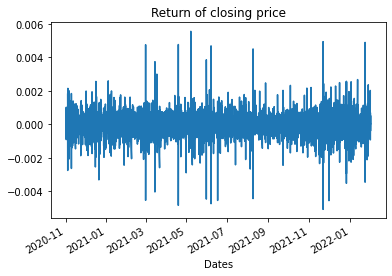

In [6]:
df[target_price].plot()
plt.title('Return of closing price')
plt.show()

In [7]:
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, target_column)

In [8]:
if nn_type_classification:
    y_train = sc_target.inverse_transform(y_train)
    y_val = sc_target.inverse_transform(y_val)
    y_test = sc_target.inverse_transform(y_test)

## Econmetric measures

Definition of cumulated returns

In [9]:
def cumulated_return(y_pred, ret, start_capital=1000, dtype=None):
    assert y_pred.flatten().shape == ret.flatten().shape
    balance = [start_capital]
    signal = 0
    for i, d in enumerate(y_pred[:-1]):
        signal = signal if d == 1 else d
        if signal == 0:
            balance.append(balance[-1])
        elif signal == 2:
            balance.append(balance[-1] * ret[i])
        else:
            raise ValueError()
    balance = np.array(balance, dtype=dtype)
    return balance

In [10]:
#!!! for testing purposes
tmp_type = 'train'

X = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)
for i in range(lag):
    diff = np.abs(df.loc[eval(f"index_{tmp_type}")].iloc[i:-(lag - i + 1)].values - X[:,-(lag - i)]).sum(axis=0)
    assert diff[0] < 1e-6 and diff[1] < 0.5, 'df and X inversed are not the same'

X_ret_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 0]
y_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]

a1 = sc_target.inverse_transform(eval(f"y_{tmp_type}")).flatten()
a2 = eval(f"y_{tmp_type}").flatten()
b = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]
cc = df.loc[eval(f"index_{tmp_type}")].iloc[(lag - 1):-(h+1), 1].values
print(np.abs(cc[1:] - a1[:-1]).sum(axis=0))
print(np.abs(cc[1:] - a2[:-1]).sum(axis=0))
print(np.abs(cc - b).sum(axis=0))

38314.900598420994
0.0
0.0


In [11]:
print((index_train[0:-(lag+1)] == X_train_index[:, 0]).all())
print((index_train[(lag-1):-(h+1)] == X_train_index[:, -1]).all())

True
True


## read in data for econmic metric

In [12]:
def econ_metrics(y_pred, X_ret, risk_free=0.0031):  # Risk free rate must be given
    x = cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype)
    print(f'Portfolio return: {x[-1] / x[0] - 1}')
    print(f'Std of returns: {np.std(x[1:] / x[:-1])}')
    print(f'Sharpe ratio: {((x[-1] / x[0]) - 1 - risk_free) / np.std(x[1:] / x[:-1])}')
    print()
    
    n = 6 * 24 * 252  # banking days per year
    mu_annum = ((x[-1]/x[0]) ** (n / x.shape[0])) - 1
    print(f'Return per annum: {mu_annum}')
    std_annum = np.std(x[1:] / x[:-1]) * (n)**0.5
    print(f'Std of returns per annum: {std_annum}')
    print(f'Sharpe ratio per annum: {(mu_annum - risk_free) / std_annum}')

In [13]:
X_train.shape[-1] == my_LSTM_model.input_shape[-1]
print(X_train.shape[-1])
print(my_LSTM_model.input_shape[-1])

2
2


In [ ]:
def investment_lengths(y):
    count_length = {0: [], 1: [], 2: []}
    length = 0
    current = y.flatten()[0]
    for i, t in enumerate(y.flatten()):
        if t == current:
            length += 1
        else:
            count_length[current].append(length)
            current = t
            length = 1
    return count_length
def investment_lengths_buy_sell(y):
    count_length = {0: [], 2: []}
    length = 0
    current = y.flatten()[0]
    for i, t in enumerate(y.flatten()):
        if t == current or t == 1:
            length += 1
        else:
            count_length[current].append(length)
            current = t
            length = 1
    return count_length
def changed_number_of_investments(v):
    return sum([len(v) for k, v in count_length.items()])
def investment_length_stats(v, dec_point=4):
    return {k: {'number': len(v), 'mean': np.mean(v).round(dec_point), 'std': np.std(v).round(dec_point), 'max': np.max(v)} for k, v in v.items()}

In [56]:
def result_output2(tmp_type):
    print(tmp_type)

    y = eval(f"y_{tmp_type}")
    if nn_type_classification:
        y_pred = np.argmax(predictions(
            my_LSTM_model,
            eval(f"X_{tmp_type}")
        ), axis=1)
    else:
        y = strategy(y)
        if X_train.shape[-1] - 1 == my_LSTM_model.input_shape[-1]:
            i = df.columns.to_list().index('strategy')
            y_pred = strategy(predictions(
                my_LSTM_model,
                np.delete(eval(f"X_{tmp_type}"), i, -1)
            ))
        else:
            y_pred = strategy(predictions(
                my_LSTM_model,
                eval(f"X_{tmp_type}")
            ))
    print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
    print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
    print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

    X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, target_price_column] + 1
    plt.plot(eval(f"index_{tmp_type}")[lag-1:-(h+1)][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

    c = Counter(y.flatten())
    for i in range(3):
        c.update({i: 0})
    p = [i[1]/y.shape[0] for i in sorted(c.items(), key=lambda x: x[0])]
    x = np.concatenate(
        [
            cumulated_return(
                np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
                X_ret[1:],
                dtype=dtype
            )[:,np.newaxis] for i in range(50)
        ], axis=-1
    )
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1), label='random', color='gray')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
    plt.plot(eval(f"index_{tmp_type}")[(lag-1):-(h+1)][1:], cumulated_return(y, X_ret, dtype=dtype)[:-1], label='oracle')
    plt.legend()
    plt.semilogy()
    plt.show()
    econ_metrics(y_pred, X_ret)
    print('=============================')
    print('Investment lengths')
    print('y_true')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths(y)), orient='index'))
    print('y_pred')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths(y_pred)), orient='index'))
    print('Investment lengths for only buy and sell (hold is prolongation of previous)')
    print('y_true')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths_buy_sell(y)), orient='index'))
    print('y_pred')
    print(pd.DataFrame.from_dict(investment_length_stats(investment_lengths_buy_sell(y_pred)), orient='index'))

train
Accuracy: 0.5360456109046936
Accuracy: 0.47603005170822144
KL_Divergence: 156361.609375
              precision    recall  f1-score   support

         0.0       0.52      0.58      0.55     18370
         1.0       0.88      0.32      0.46      1422
         2.0       0.54      0.51      0.53     18798

    accuracy                           0.54     38590
   macro avg       0.65      0.47      0.51     38590
weighted avg       0.55      0.54      0.53     38590



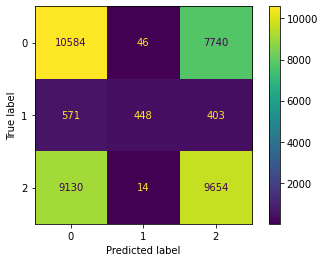

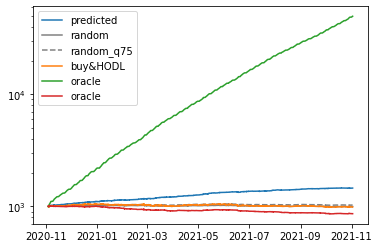

Portfolio return: 0.4571225643157959
Std of returns: 0.0002223982010036707
Sharpe ratio: 2041.4848783255322

Return per annum: 0.42477758821437916
Std of returns per annum: 0.0423655438956385
Sharpe ratio per annum: 9.953314638261745
Investment lengths
y_true
   number    mean     std  max
0    9823  1.8701  1.2605   11
1     815  1.7448  6.4451  149
2    9761  1.9256  1.3097   14
y_pred
   number    mean      std  max
0    8401  2.4141   2.0038   21
1      70  7.2571  20.7686  149
2    8367  2.1270   1.8905   45
Investment lengths for only buy and sell (hold is prolongation of previous)
y_true
   number    mean     std  max
0    9580  2.0063  2.3599  153
2    9579  2.0219  1.4235   14
y_pred
   number    mean     std  max
0    8359  2.4772  2.8598  151
2    8360  2.1386  1.9162   45


In [57]:
result_output2('train')

val
Accuracy: 0.4910830855369568
Accuracy: 0.482818603515625
KL_Divergence: 19454.537109375
              precision    recall  f1-score   support

         0.0       0.48      0.51      0.50      2220
         1.0       0.68      0.15      0.24       129
         2.0       0.50      0.49      0.49      2249

    accuracy                           0.49      4598
   macro avg       0.55      0.38      0.41      4598
weighted avg       0.50      0.49      0.49      4598



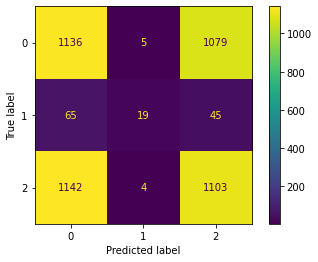

ValueError: x and y must have same first dimension, but have shapes (4598,) and (4597,)

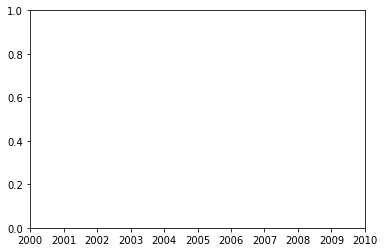

In [16]:
result_output2('val')

test
Accuracy: 0.4997825026512146
Accuracy: 0.48151370882987976
KL_Divergence: 19631.8359375
              precision    recall  f1-score   support

         0.0       0.49      0.53      0.51      2214
         1.0       0.68      0.14      0.24       119
         2.0       0.51      0.48      0.49      2265

    accuracy                           0.50      4598
   macro avg       0.56      0.39      0.41      4598
weighted avg       0.50      0.50      0.50      4598



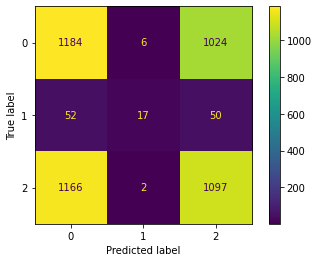

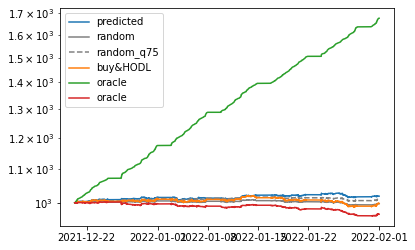

Portfolio return: 0.018872857093811035
Std of returns: 0.00025141998776234686
Sharpe ratio: 62.73509610031574

Return per annum: 0.15903874589433564
Std of returns per annum: 0.04789402288200522
Sharpe ratio per annum: 3.255912460695071
Investment lengths
y_true
   number    mean     std  max
0    1223  1.8095  1.1709   10
1      82  1.4512  1.4155    8
2    1215  1.8642  1.2381    9
y_pred
   number    mean     std  max
0     993  2.4179  2.0939   20
1      10  2.5000  1.9621    7
2     992  2.1885  1.9530   26
Investment lengths for only buy and sell (hold is prolongation of previous)
y_true
   number    mean     std  max
0    1198  1.9157  1.3620   13
2    1199  1.9199  1.2865   11
y_pred
   number    mean     std  max
0     989  2.4408  2.1368   20
2     990  2.2051  1.9719   26


In [61]:
result_output2('test')